### Imports and CUDA

In [282]:
# Matplotlib
import requests
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [283]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Objective

#### To develop a model that predicts taxi availability within a specific area for the next three hours. This means that if the model is run at 12 PM, it will provide predicted taxi availability for 1 PM, 2 PM, and 3 PM.

The area of interest is defined by the following geographical boundaries:

    North: 1.35106
    South: 1.32206
    East: 103.97839
    West: 103.92805

To identify the taxis currently available within this region, we use the TaxiAvailabilityScript.py.

This script collects real-time data, which serves as input for our predictive model.

By leveraging historical taxi availability trends and real-time data, our model aims to provide accurate forecasts, helping commuters, ride-hailing services, and urban planners make informed decisions.


# **To-Do List for Taxi Availability Prediction**

## **Step 1: Cleaning the Taxi Availability Data**
The first step involves retrieving and preprocessing the taxi availability dataset. The dataset consists of the following columns:

1. **DateTime**  
2. **Taxi Available Throughout Singapore**  
3. **Taxi Available in Selected Box Area**  
4. **Coordinates[]**  

For our specific use case, **the coordinates column will not be used for now**.  

To prepare the data for the neural network:  
- **Inputs:** We will use `DateTime` and `Taxi Available Throughout Singapore` as features.  
- **Output:** `Taxi Available in Selected Box Area` will be the target variable.  
- **DateTime Conversion:** Since `DateTime` is not in a format suitable for neural networks, we will extract relevant features:
  - **IsWeekend**: A binary feature (1 if it's a weekend, 0 otherwise).  
  - **Hour**: Transformed into a numerical value between **1 and 24** (avoiding 0, which may cause training issues).  

---

## **Step 2: Adding Additional Features**  
*(Partially completed; will be refined over time)*  

Aside from the existing columns, we aim to incorporate additional features that may improve prediction accuracy:  

1. **ERP Rates (Electronic Road Pricing) at the given time and location**  
   - Uncertain if this will significantly impact predictions. Further analysis is needed.  

2. **Number of LTA (Land Transport Authority) gantry locations**  
   - Again, its usefulness remains uncertain—further evaluation required.  

3. **Traffic Incidents in the Selected Area**  
   - A script (`TrafficIncidentScript.py`) has been written to update `traffic_incident.csv` with the latest traffic incidents.  
   - Over time, as the dataset grows, we hope this feature will become useful.  

4. **Number of Taxi Stands in the Area**  
   - Currently **not useful** because our area of interest is fixed.  
   - However, if we allow dynamic selection of areas in the future, this could become relevant.  

5. **Temperature at a Given Time and Date** *(To be implemented)*  

6. **Rainfall Data** *(To be implemented)*  

To ensure all features align properly, we will **synchronize all datasets based on DateTime** before feeding them into the model.  

---

## **Step 3: Creating the Training-Test Split**  
- Initially, we will perform an **80/20 Training-Test split** for simplicity.  
- In the future, we may introduce a **Training-Validation-Test split** to further refine model performance.  

---

## **Step 4: Building the Model**  
We will begin with an **LSTM model**, as LSTMs are well-suited for time-series forecasting.  
- **Initial Limitation:** The model, in its basic form, will only predict the next hour.  
- **Future Improvement:** A **sliding window approach** will be explored and implemented to extend predictions further.  

---

## **Step 5: Model Evaluation and Improvement**  
- After the initial model is trained, we will assess its performance.  
- Based on results, we will explore potential improvements, such as hyperparameter tuning, architectural modifications, or additional feature engineering.  

---

This structured approach will guide the development of a robust and accurate taxi availability prediction model. 🚖💡


## **Preparing the taxi_availability data here.**

Normalization of certain inputs are done as well, but I am unsure if it is the right thing to do as well.

In [284]:
# weather_file_path = "merged_weather.csv"
# weather_df = pd.read_csv(weather_file_path, delimiter=",")

# weather_df = weather_df[::-1]


In [285]:
# taxi_availability_file_path = "taxi_availability.csv"

# taxi_df = pd.read_csv(taxi_availability_file_path, delimiter=",")

merged_weather_taxi_df = "merged_file.csv"
taxi_df = pd.read_csv(merged_weather_taxi_df, delimiter = ",")

#Adjusting for weather parameters
taxi_df = taxi_df.drop(columns = "stationId")

#Adjusting for taxi_vailability parameters
taxi_df_coordinates = taxi_df["Coordinates[]"]
taxt_df_datetime = taxi_df["DateTime"]
taxi_df = taxi_df.drop(columns = "Coordinates[]")
taxi_df["DateTime"] = pd.to_datetime(taxi_df["DateTime"])

taxi_df["IsWeekend"] = (taxi_df["DateTime"].dt.weekday >= 5).astype(int)
taxi_df["Hour"] = taxi_df["DateTime"].dt.hour + 1  # Convert 0-23 to 1-24
taxi_df = taxi_df.drop(columns = "DateTime")

print(taxi_df.dtypes)

Taxi Available throughout SG             int64
Taxi Available in Selected Box Area      int64
temp_value                             float64
humidity_value                         float64
rainfall_value                         float64
IsWeekend                                int64
Hour                                     int32
dtype: object


### Converting all dtypes into float32

In [286]:
# taxi_df=taxi_df[:5120]
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns
print("numeric_columns",numeric_columns)
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')
numeric_columns = taxi_df.select_dtypes(include=['int64', 'int32','float64','object']).columns

# Convert selected columns to float32
taxi_df[numeric_columns] = taxi_df[numeric_columns].astype('float32')




numeric_columns Index(['Taxi Available throughout SG', 'Taxi Available in Selected Box Area',
       'temp_value', 'humidity_value', 'rainfall_value', 'IsWeekend', 'Hour'],
      dtype='object')


### Normalizing all values

In [287]:
#---------------Normalise-----------------------
# Drop 'DateTime' as it's no longer needed
# Normalize the 'Hour' and 'IsWeekend' columns (if needed)


data_min = taxi_df.min(axis=0)
data_max = taxi_df.max(axis=0)
taxi_df_normalized = (taxi_df - data_min) / (data_max - data_min)

# scaler = MinMaxScaler()
# taxi_df[["Hour", "IsWeekend", "Taxi Available throughout SG","Taxi Available in Selected Box Area"]] = scaler.fit_transform(taxi_df[["Hour", "IsWeekend","Taxi Available throughout SG","Taxi Available in Selected Box Area"]])
# taxi_df = taxi_df.apply(pd.to_numeric, errors='coerce')
taxi_df_output_normalized  = taxi_df_normalized["Taxi Available in Selected Box Area"]
taxi_df_normalized = taxi_df_normalized.drop(columns = "Taxi Available in Selected Box Area")
taxi_df_normalized.to_csv("checker.csv", index=False)  # Set index=False to exclude row numbers

# Convert to NumPy arrays
input_data = taxi_df_normalized.values  # Shape: (5120, num_features)
output_data = taxi_df_output_normalized.values  # Shape: (5120,)
# taxi_df_output = taxi_df["Taxi Available in Selected Box Area"]
# input_data = taxi_df.values  # Shape: (5120, num_features)
# output_data = taxi_df_output.values  # Shape: (5120,)

print("Input Data: ",input_data.shape)
print("Output Data: ",output_data.shape)

# Define sequence length



Input Data:  (8482, 6)
Output Data:  (8482,)


### No Normalization Style

In [288]:
# #---------------No Normalization-----------------------

# # Drop 'DateTime' as it's no longer needed
# taxi_df_no_norm = taxi_df  # Remove DateTime but keep raw values

# # Separate input and output data
# taxi_df_output_no_norm = taxi_df_no_norm["Taxi Available in Selected Box Area"]
# taxi_df_no_norm = taxi_df_no_norm.drop(columns=["Taxi Available in Selected Box Area"])

# # Save to CSV for checking
# taxi_df_no_norm.to_csv("checker_no_norm.csv", index=False)  # Set index=False to exclude row numbers

# # Convert to NumPy arrays (raw values)
# input_data = taxi_df_no_norm.values  # Shape: (5120, num_features)
# output_data = taxi_df_output_no_norm.values  # Shape: (5120,)

# print("Input Data: ", input_data.shape)
# print("Input Data: ", input_data[0])

# print("Output Data: ", output_data.shape)
# print("Input Data: ", output_data[0])


### Create Sequence Function

In [289]:
seq_length = 24
pred_horizon = 3  # Number of future time steps to predict

def create_sequences(data, labels, seq_length, pred_horizon):
    xs, ys = [], []
    for i in range(0, len(data), seq_length):  # Start from 0 and increment by seq_length
        if i + seq_length + pred_horizon <= len(data):  # Ensure enough data for prediction horizon
            xs.append(data[i:i + seq_length])  # Input sequence (continuous)
            ys.append(labels[i + seq_length : i + seq_length + pred_horizon])  # Next 3 values
    return np.array(xs), np.array(ys)


In [290]:

X, y = create_sequences(input_data, output_data, seq_length,pred_horizon)
print("Input shape:", xs.shape)   # Expected: (num_samples, seq_length, num_features)
print("Output shape:", ys.shape)  # Expected: (num_samples, pred_horizon)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)  # Add channel dim
y = torch.tensor(y[:, None], dtype=torch.float32)

# Split into training (80%) and testing (20%)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
trainX = torch.tensor(trainX, dtype=torch.float32)  # Shape: (train_size, 24, num_features)
trainY = torch.tensor(trainY, dtype=torch.float32)  # Shape: (train_size,)
testX = torch.tensor(testX, dtype=torch.float32)    # Shape: (test_size, 24, num_features)
testY = torch.tensor(testY, dtype=torch.float32)    # Shape: (test_size,)

train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

batch_sizes = 17  # You can adjust the batch size as needed
#Shuffle is false because you need it to be in time sequenced, but please double check
train_loader = DataLoader(train_dataset, batch_size=batch_sizes, shuffle=False,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_sizes, shuffle=False, drop_last=True)

# Example of accessing a batch of data
for inputs, targets in train_loader:
    print(f'Inputs: {inputs.shape}, Targets: {targets.shape}')
    break  # Only print the first batch for verification

Input shape: (353, 24, 6)
Output shape: (353, 3)
Inputs: torch.Size([17, 24, 6]), Targets: torch.Size([17, 1, 3])


C:\Users\nicho\AppData\Local\Temp\ipykernel_35544\3746224765.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX = torch.tensor(trainX, dtype=torch.float32)  # Shape: (train_size, 24, num_features)
C:\Users\nicho\AppData\Local\Temp\ipykernel_35544\3746224765.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY = torch.tensor(trainY, dtype=torch.float32)  # Shape: (train_size,)
C:\Users\nicho\AppData\Local\Temp\ipykernel_35544\3746224765.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testX = torch.tensor(testX, dtype=t

In [291]:
print("test_loader",len(test_loader))

test_loader 4


In [292]:
class LSTM_pt(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_pt, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # # LayerNorm applied to the hidden state
        # self.layer_norm = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.ReLU()  # Helps prevent constant outputs
        )

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.randn(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Apply LayerNorm to the output of the LSTM
        # out = self.layer_norm(out)

        # Pass only the last timestep's output to the FC layer
        out = self.fc(out[:, -1, :])  

        return out, hn, cn

In [293]:
def train(model, dataloader,num_layers, hidden_size, num_epochs, learning_rate, device, ):
    # Set the loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  # Set the model to training mode
    loss_graph = []
    
    for epoch in range(num_epochs):
        loss=0
        hidden_state, cell_state = None, None   
        optimizer.zero_grad() #Double check if this is the right position
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if batch_idx == len(train_loader) - 1:  
                break  # Skip the last batch
            # Initialize hidden state and cell state for each batch
            # Forward pass
            output, cell_state, hidden_state = model(inputs,cell_state, hidden_state)
            # Calculate loss
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            hidden_state = hidden_state.detach()
            cell_state = cell_state.detach()
        loss_graph.append(loss.item())

        if epoch %50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss/len(dataloader)}')
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss/len(dataloader)}')

    return loss_graph

c:\Users\nicho\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([17, 1, 3])) that is different to the input size (torch.Size([17, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/150, Loss: 0.0015162533381953835
Epoch 51/150, Loss: 0.0007538017234764993
Epoch 101/150, Loss: 0.0007746617775410414
Epoch 150/150, Loss: 0.0007212620112113655


Text(0, 0.5, 'Loss')

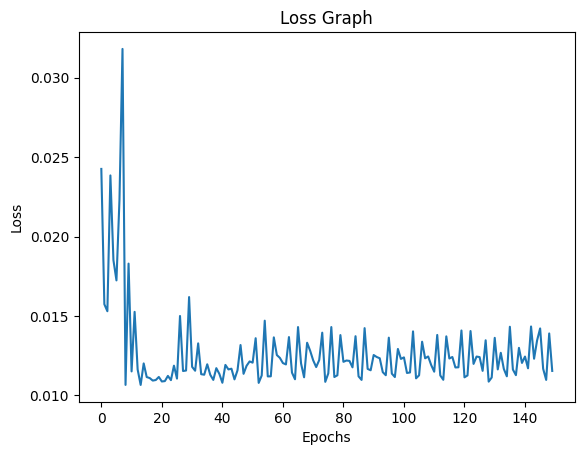

In [ ]:
# Define the model parameters
# Following the research paper's instructions
input_size = 6
hidden_size = 50
num_layers = 1 # Can be changed to stack multiple LSTM layers!
output_size = 3
dataloader = train_loader
#Create the model
model = LSTM_pt(input_size, hidden_size, num_layers, output_size).to(device)
loss_graph = train(model, dataloader,num_layers, hidden_size, num_epochs = 300, learning_rate = 0.01, device = device)

plt.plot(loss_graph)
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [295]:
print(len(test_loader))

4


In [296]:
model.eval()

# Initialize variables to track loss
loss_value = 0
num_batches = 0

# Define the loss function
criterion = torch.nn.MSELoss()

# Initialize hidden state and cell state
hidden_state, cell_state = None, None  

# Disable gradient computation for validation
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        if batch_idx == len(test_loader) - 1:  
            break  # Skip the last batch

        # Forward pass
        output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)

        # Denormalize predictions and targets (for all 3 time steps)
        output_denorm = output * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]
        targets_denorm = targets * (data_max["Taxi Available in Selected Box Area"] - data_min["Taxi Available in Selected Box Area"]) + data_min["Taxi Available in Selected Box Area"]

        # Compute loss on normalized data
        loss_value += criterion(output, targets)

        # Print a sample of the normalized and denormalized values
        print("Normalized output[0]:", output[0].tolist())  
        print("Normalized target[0]:", targets[0].tolist())  
        print("Denormalized output[0]:", output_denorm[0].tolist())  
        print("Denormalized target[0]:", targets_denorm[0].tolist())  
        print("-" * 50)

# Compute average loss
loss_value = loss_value / (len(test_loader) - 1)
print("Predicted output shape:", output.shape)
print("True output shape:", targets.shape)
print(f'Average Validation Loss: {loss_value:.4f}')


Normalized output[0]: [0.43709200620651245, 0.4402756690979004, 0.42612424492836]
Normalized target[0]: [[0.37662336230278015, 0.4588744640350342, 0.380952388048172]]
Denormalized output[0]: [101.96825408935547, 102.70368194580078, 99.43470001220703]
Denormalized target[0]: [[88.0, 107.0, 89.0]]
--------------------------------------------------
Normalized output[0]: [0.48632216453552246, 0.5029631853103638, 0.48521697521209717]
Normalized target[0]: [[0.2943722903728485, 0.350649356842041, 0.350649356842041]]
Denormalized output[0]: [113.34042358398438, 117.18449401855469, 113.08512115478516]
Denormalized target[0]: [[69.0, 82.0, 82.0]]
--------------------------------------------------
Normalized output[0]: [0.4843446910381317, 0.5003383755683899, 0.4821070432662964]
Normalized target[0]: [[0.4458874464035034, 0.4545454680919647, 0.4675324559211731]]
Denormalized output[0]: [112.88362121582031, 116.57816314697266, 112.36672973632812]
Denormalized target[0]: [[104.0, 106.0, 109.0]]
--

In [297]:

# model.eval()

# # Initialize variables to track loss
# loss_value = 0
# num_batches = 0

# # Define the loss function
# criterion = torch.nn.MSELoss()

# # Initialize hidden state and cell state
# hidden_state, cell_state = None, None  

# # Disable gradient computation for validation
# with torch.no_grad():
#     for batch_idx, (inputs, targets) in enumerate(test_loader):
#         if batch_idx == len(test_loader) - 1:  
#             break  # Skip the last batch
#         # Forward pass
#         output, cell_state, hidden_state = model(inputs, cell_state, hidden_state)
#         print("Predicted output: ", output)
#         print("True Output: ", targets)

#         # Compute loss
#         # Compute loss
#         loss_value += criterion(output, targets)
# # Compute average loss
# loss_value = loss_value / (len(test_loader) -1 )

# # Print validation results
# print(f'Average Validation Loss: {loss_value:.4f}')
